# Datenanlyse zur Umfrage Persönliche Expertise

---

## Import libraries

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import shapiro, levene
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import rlm
import seaborn as sns
# Import zusätzlicher Bibliotheken für robuste Tests
from scipy.stats import mannwhitneyu, kruskal
from scipy.stats import ranksums
import scipy.stats as stats


In [94]:
def cronbach_alpha(df):
    """
    Berechnet Cronbach's Alpha für die interne Konsistenz eines Konstrukts.
    
    Parameter:
    df: DataFrame mit den Items eines Konstrukts (nur numerische Werte)
    
    Return:
    alpha: Cronbach's Alpha-Wert
    """
    # Entferne Zeilen mit fehlenden Werten
    df_clean = df.dropna()
    
    if df_clean.empty or df_clean.shape[1] < 2:
        return np.nan
    
    # Anzahl Items
    k = df_clean.shape[1]
    
    # Varianz jedes Items
    item_variances = df_clean.var(axis=0, ddof=1)
    
    # Varianz der Summe aller Items
    total_variance = df_clean.sum(axis=1).var(ddof=1)
    
    # Cronbach's Alpha
    alpha = (k / (k - 1)) * (1 - (item_variances.sum() / total_variance))
    
    return alpha

def evaluate_cronbach_alpha(alpha):

    if alpha >= 0.9:
        return "Exzellent"
    elif alpha >= 0.8:
        return "Gut"
    elif alpha >= 0.7:
        return "Akzeptabel"
    elif alpha >= 0.6:
        return "Fragwürdig"
    else:
        return "Inakzeptabel"

def analyze_construct_reliability(df, item_columns, construct_name):
    """
    Analysiert die Reliabilität eines Konstrukts und gibt detaillierte Informationen aus.
    
    Parameter:
    df: DataFrame mit den Daten
    item_columns: Liste der Spaltennamen für die Items des Konstrukts
    construct_name: Name des Konstrukts für die Ausgabe
    """    
    available_columns = [col for col in item_columns if col in df.columns]
    missing_columns = [col for col in item_columns if col not in df.columns]
    
    if missing_columns:
        print(f"Fehlende Spalten: {missing_columns}")
    
    if len(available_columns) < 2:
        print(f"Nicht genügend Items verfügbar ({len(available_columns)}) für Reliabilitätsanalyse")
        return None
    
    construct_data = df[available_columns].copy()
    
    # Berechne Cronbach's Alpha
    alpha = cronbach_alpha(construct_data)
    evaluation = evaluate_cronbach_alpha(alpha)
    
    print(f"Anzahl Items: {len(available_columns)}")
    print(f"Gültige Fälle: {construct_data.dropna().shape[0]} von {len(df)}")
    print(f"Cronbach's α = {alpha:.3f} ({evaluation})")
    
    # Item-Statistiken
    print(f"\nItem-Statistiken:")
    item_stats = construct_data.describe()
    for col in available_columns:
        mean_val = item_stats.loc['mean', col]
        std_val = item_stats.loc['std', col]
        print(f"  {col}: M = {mean_val:.2f}, SD = {std_val:.2f}")
    
    correlations = construct_data.corr()
    print(f"\nInter-Item-Korrelationen:")
    print(f"  Durchschnitt: {correlations.values[np.triu_indices_from(correlations.values, k=1)].mean():.3f}")
    print(f"  Bereich: [{correlations.values[np.triu_indices_from(correlations.values, k=1)].min():.3f}, {correlations.values[np.triu_indices_from(correlations.values, k=1)].max():.3f}]")
    
    print(f"\nCronbach's α wenn Item entfernt:")
    for col in available_columns:
        subset_columns = [c for c in available_columns if c != col]
        if len(subset_columns) >= 2:
            alpha_without = cronbach_alpha(construct_data[subset_columns])
            change = alpha_without - alpha
            print(f"  ohne {col}: α = {alpha_without:.3f} (Δ = {change:+.3f})")
    
    return {
        'alpha': alpha,
        'evaluation': evaluation,
        'n_items': len(available_columns),
        'n_cases': construct_data.dropna().shape[0],
        'available_columns': available_columns
    }
    
def summarize_ttest(t_stat, p_value, group1_name, group2_name, alpha=0.05):
    signif = "signifikant" if p_value < alpha else "nicht signifikant"    
    print(f"t-Test ({group1_name} vs. {group2_name}): t = {t_stat:.3f}, p = {p_value:.3f}, {signif}.")
    print(f"(α = {alpha})")

def summarize_mann_whitney(group1_data, group2_data, group1_name, group2_name, alpha=0.05):
    """
    Führt Mann-Whitney-U-Test durch und gibt Ergebnisse aus (robuste Alternative zu t-Test)
    """
    from scipy.stats import mannwhitneyu
    statistic, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
    signif = "signifikant" if p_value < alpha else "nicht signifikant"
    
    print(f"Mann-Whitney-U-Test ({group1_name} vs. {group2_name}):")
    print(f"   U = {statistic:.0f}, p = {p_value:.4f}, {signif}")
    print(f"   {group1_name}: Median = {group1_data.median():.1f}, n = {len(group1_data)}")
    print(f"   {group2_name}: Median = {group2_data.median():.1f}, n = {len(group2_data)}")
    print(f"   (α = {alpha}, robuster Test bei nicht-normalverteilten Daten)")
    return statistic, p_value
    
def summarize_anova(anova_df, alpha=0.05):
    """
    Druckt eine übersichtliche Zusammenfassung der ANOVA-Ergebnisse inklusive
    Effektstärken (η²) und kurzer Interpretation.
    
    Parameter:
    - anova_df: pandas DataFrame mit Spalten ['sum_sq', 'df', 'F', 'PR(>F)']
                und Index = Effektnamen (z.B. 'Priming', 'Professionalität', 'Residual').
    - alpha:    Signifikanzniveau (Standard: 0.05).
    """
    anova_df = anova_df.copy()
    anova_df['eta_sq'] = anova_df['sum_sq'] / anova_df['sum_sq'].sum()
    
    def effect_size_label(eta):
        if eta < 0.01:
            return "vernachlässigbar"
        elif eta < 0.06:
            return "klein"
        elif eta < 0.14:
            return "mittel"
        else:
            return "groß"
    
    for name, row in anova_df.iterrows():
        if name.lower() == 'residual':
            continue  
        F = row['F']
        p = row['PR(>F)']
        eta = row['eta_sq']
        signif = "signifikant" if p < alpha else "nicht signifikant"
        size_label = effect_size_label(eta)
        
        print(f"Effekt '{name}': F({int(row['df'])}) = {F:.2f}, p = {p:.3f}, η² = {eta:.3f} ({size_label}), {signif}.")
    print(f"(α = {alpha})")


## Import data from csv

In [95]:
filename = 'data/export_2407.csv'
df = pd.read_csv(filename, sep=';')

In [96]:
df.head()

,lfdn,external_lfdn,tester,dispcode,lastpage,quality,duration,c_0001,c_0002,c_0003,...,rnd_pg_7356560_3,rnd_pg_7356560_4,rnd_pg_7356560_5,rnd_pg_7356560_6,rnd_pg_7356570_1,rnd_pg_7356570_2,rnd_pg_7356570_3,rnd_pg_7356570_4,rnd_pg_7356570_5,rnd_pg_7356570_6
0,176,0,0,31,7356546,-77,783,3,-66,-66,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77
1,178,0,0,31,7356546,-77,1691,2,-66,-66,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77
2,181,0,0,31,7356546,-77,865,-66,1,-66,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77
3,182,0,0,31,7356546,-77,536,-66,2,-66,...,7356565,7356566,7356563,7356561,-77,-77,-77,-77,-77,-77
4,184,0,0,31,7356546,-77,680,1,-66,970,...,-77,-77,-77,-77,-77,-77,-77,-77,-77,-77


In [97]:
df['priming'] = df['c_0001'].replace(-66, np.nan).fillna(df['c_0002']).astype(int)

In [98]:
def classify_professional(row):
    design_jahre_column = 'v_228'  
    if row[design_jahre_column] > 2:
        return True

    cvpa_columns = ['v_8978', 'v_9154', 'v_9155', 'v_9156', 'v_9157', 'v_9158', 'v_9159', 'v_9160', 'v_9308']
    for col in cvpa_columns:
        if row[col] < 2:
            return False
    
    # Check if sum of CVPA scores is less than 34
    cvpa_sum = sum(row[col] for col in cvpa_columns)
    if cvpa_sum < 34:
        return False
    
    # Count correct answers for knowledge questions
    correct_answers = 0
    knowledge_answers = {
        'v_206': 3,
        'v_207': 3,
        'v_208': 2,
        'v_209': 2,
        'v_210': 3,
        'v_211': 3,
        'v_212': 2,
        'v_213': 4,
        'v_214': 1,
        'v_215': 3
    }
    
    for col, correct_value in knowledge_answers.items():
        if col in row and row[col] == correct_value:
            correct_answers += 1
    
    # Check if correct answers is less than 6
    if correct_answers < 6:
        return False
    
    return True

# Apply the classification function to create a new column
df['is_professional'] = df.apply(classify_professional, axis=1)

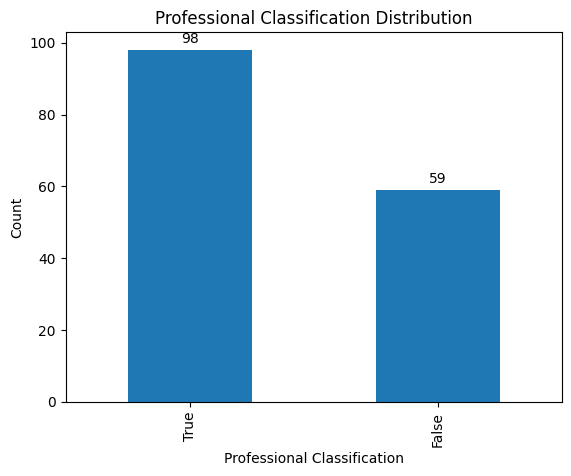

In [99]:
counts = df['is_professional'].value_counts()
ax = counts.plot(kind='bar', title='Professional Classification Distribution')
ax.set_xlabel('Professional Classification')
ax.set_ylabel('Count')

# Add value labels on top of bars
for i, v in enumerate(counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

## Forschungsfrage
- Hat die persönliche Expertise von
Konsument:innen einen Einfluss auf
Präferenzen und Preiserwartungen von
stilistisch konsistenten und
inkonsistenten Produktensembles.

## Variablen
### Abhängige Variablen (AV)

- **Preiserwartung**  
  Für welchen Preis würden Sie erwarten, dass das Produkt/Ensemble angeboten wird? (metrisch)  
  - einzeln  
  - ensemble  
  - korrektur ensemble

- **Objektive Einzelbewertung (Wertigkeit)**  
  - minderwertig ↔ hochwertig (Likert-Skala)  
  - einfach ↔ luxuriös (Likert-Skala)  
  - billig ↔ teuer (Likert-Skala)

- **Subjektive Einzelbewertung (Liking)**  
  - Das Produkt gefällt mir gut. (Likert-Skala)  
  - Ich mag das Produkt. (Likert-Skala)  
  - Ich finde das Produkt ansprechend. (Likert-Skala)

- **Objektive Ensemble-Bewertung**  
  - minderwertig ↔ hochwertig (Likert-Skala)  
  - einfach ↔ luxuriös (Likert-Skala)  
  - billig ↔ teuer (Likert-Skala)

- **Subjektive Ensemble-Bewertung**  
  - Das Ensemble gefällt mir gut. (Likert-Skala)  
  - Ich mag das Ensemble. (Likert-Skala)  
  - Ich finde das Ensemble ansprechend. (Likert-Skala)

- **Produktdarstellung**  
  - Die Kombination vermittelt mir relevante Informationen über die Produkte. (Likert-Skala)  
  - Die gezeigte Zusammenstellung hilft mir, die Produkte besser zu verstehen. (Likert-Skala)  
  - Die Präsentation erleichtert es mir, die Produkte zu beurteilen. (Likert-Skala)  
  - Durch die Präsentation kann ich mir vorstellen, welche Personen dieses Outfit tragen würden. (Likert-Skala)  
  - Durch die Präsentation kann ich mir vorstellen, in welchen beruflichen Situationen das Outfit getragen wird. (Likert-Skala)  
  - Ich verstehe, wie man die Teile elegant, seriös und professionell kombiniert. (Likert-Skala)

- **Bewertungsleichtigkeit**  
  - Es fällt mir leicht, das Outfit zu bewerten. (Likert-Skala)  
  - Ich erfasse das Outfit visuell schnell. (Likert-Skala)  
  - Ich kann mir das Outfit mit geschlossenen Augen in Erinnerung rufen. (Likert-Skala)  
  - Ich kann das Outfit später einer anderen Person beschreiben. (Likert-Skala)

- **Gesamtwirkung**  
  - uneinheitlich ↔ einheitlich (Likert-Skala)  
  - unstimmig ↔ stimmig (Likert-Skala)  
  - unharmonisch ↔ harmonisch (Likert-Skala)

- **Stileinordnung**  
  - Hippie (Likert-Skala)  
  - Hip Hop / Active Wear (Likert-Skala)  
  - Boho (Likert-Skala)

---

### Unabhängige Variablen (UV)


- **Priming-Konsistenz**  
  - konsistentes Ensemble  
  - inkonsistentes Ensemble  
  - inkonsistentes Ensemble mit nichtansprechendem Oberteil

- **Stilrichtung**  
  - HipHop × Minimalistisch

- **Produktkategorie**  
  - Oberteil

- **Expertenstatus**  
  - Experte vs. Nicht-Experte (gemäß Faktenwissen & CVPA)

> **Design:** 3 × 2-Faktor (Priming-Konsistenz × Expertenstatus), between-subjects

---

### Kontroll- und Störvariablen

- **Demografische Variablen**  
  - Alter (metrisch, Jahre)  
  - Geschlecht (nominal, z. B. m/w/d)  
  - Einkommen (metrisch oder ordinal gruppiert)  
  - Bildungsgrad (ordinal)  
  - Beruf (nominal)

- **Berufserfahrung**  
  - (metrisch, Jahre)

- **CVPA-Score**  
  - (metrisch)

- **Faktenwissen-Score**  
  - (metrisch)


## Überprüfung der Hypothesen

Wir untersuchen den Einfluss der Outfit-Konsistenz (konsistent vs. inkonsistent) auf die Preiserwartung und prüfen, ob dieser Effekt durch den Expertenstatus (Experte vs. Nicht-Experte) moderiert wird. Das subjektive Gefallen (Liking) betrachten wir dabei als potenzielle Mediatorvariable zwischen Outfit-Konsistenz und Preiserwartung.

**Nullhypothese (H₀)**  
Es existiert kein Interaktionseffekt von Outfit-Konsistenz und Expertenstatus auf die Preiserwartung. Formal:  
$$
H_0: (\mu_{\text{konsistent, Experte}} - \mu_{\text{inkonsistent, Experte}}) = (\mu_{\text{konsistent, Nicht-Experte}} - \mu_{\text{inkonsistent, Nicht-Experte}})
$$

**Alternativhypothese (H₁)**  
Der Unterschied in der Preiserwartung zwischen konsistenten und inkonsistenten Outfits ist bei Experten größer als bei Nicht-Experten. Formal:  
$$
H_1: (\mu_{\text{konsistent, Experte}} - \mu_{\text{inkonsistent, Experte}}) > (\mu_{\text{konsistent, Nicht-Experte}} - \mu_{\text{inkonsistent, Nicht-Experte}})
$$

> *Anmerkungen:*  
> - Die primäre Analyse erfolgt mittels zweifaktorieller ANOVA (Outfit-Konsistenz × Expertenstatus) bei α = 0,05.  
> - Ergänzend wird eine Mediationsanalyse durchgeführt, um zu prüfen, ob das subjektive Gefallen (Liking) den Einfluss der Outfit-Konsistenz auf die Preiserwartung vermittelt.

### Data cleaning

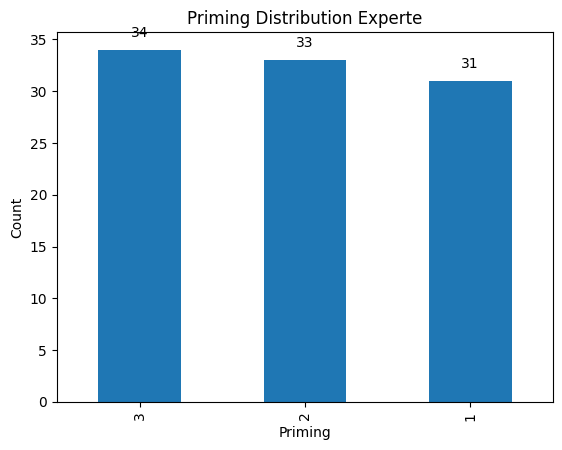

In [100]:
# Distribution of priming levels
filtered_rows = df[df['is_professional']].copy()
priming_counts = filtered_rows['priming'].value_counts()
ax = priming_counts.plot(kind='bar', title='Priming Distribution Experte')
ax.set_xlabel('Priming')
ax.set_ylabel('Count')
ax.set_yticks(range(0, priming_counts.max() + 5, 5))

# Add value labels on top of bars
for i, v in enumerate(priming_counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

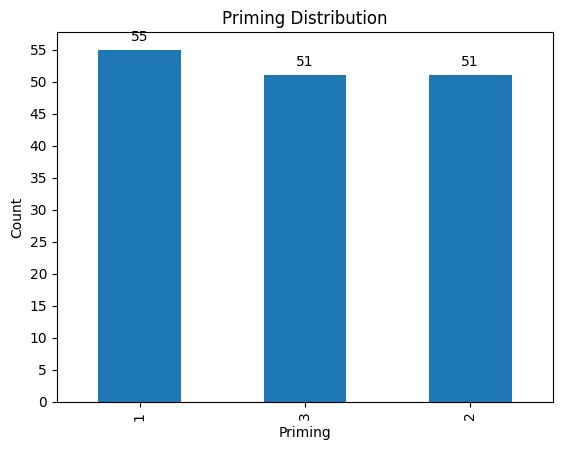

In [101]:
# Alternative priming distribution (column c_0002 replaced)
# Using combined 'priming' column instead
priming_counts = df['priming'].value_counts()
ax = priming_counts.plot(kind='bar', title='Priming Distribution')
ax.set_xlabel('Priming')
ax.set_ylabel('Count')
ax.set_yticks(range(0, priming_counts.max() + 5, 5))

# Add value labels on top of bars
for i, v in enumerate(priming_counts.values):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.show()

In [102]:
rename_map = dict()
inverse_map = dict()
def reduce_columns(row):
    # Get all columns that start with 'v_'
    v_columns = [col for col in row.index if col.startswith('v_')]

    # Filter out columns that have negative values
    valid_columns = ['priming', 'is_professional']  # Always include these columns
    counter = 0
    for col in v_columns:
        try:
            if int(row[col]) >= 0:
                valid_columns.append(col)
                counter += 1
                if f"Q{counter}" not in rename_map:
                    rename_map[f"Q{counter}"] = col
                else:
                    rename_map[f"Q{counter}"] += col
                
                if col not in inverse_map:
                    inverse_map[col] = f"Q{counter}"
                else:
                    inverse_map[col] = f"Q{counter}"
        except ValueError:
            # If conversion to int fails, skip this column
            continue
    
    # Create the result series with renamed columns
    result = {}
    for col in valid_columns:
        if col in inverse_map:
            # Use the Q-column name from inverse_map
            result[inverse_map[col]] = row[col]
        else:
            # Keep original column name for non-v columns
            result[col] = row[col]
    
    return pd.Series(result)
    


combined_df = df.apply(reduce_columns, axis=1)
combined_df.head()

,priming,is_professional,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Q90,Q91,Q92,Q93,Q94,Q95,Q96,Q97,Q98,Q99
0,3,True,2,0,0,0,0,0,0,0,...,5,4,3,4,3,2,51,1,2,4
1,2,True,1,1,1,0,1,0,0,0,...,5,5,4,5,1,1,47,1,2,4
2,1,True,2,0,0,0,0,0,0,0,...,5,5,4,4,2,2,60,2,2,5
3,2,False,2,0,0,0,0,0,0,0,...,5,5,5,4,1,1,22,1,1,1
4,1,True,2,0,0,0,1,0,0,0,...,4,5,4,4,1,3,19,1,1,3


In [103]:
def get_q_columns_from_v(v_cols, rename_map):
    """
    Given a list of original 'v_' column names and the list of rename_maps,
    return a set of corresponding new 'Q' column names across all subsets.
    """
    q_cols_set = set()
    for v in v_cols:
        if v in rename_map:
            q_cols_set.add(rename_map[v])
    return q_cols_set

# Example usage:
q_set = get_q_columns_from_v(['v_10915'], inverse_map)
print(q_set)

{'Q42'}


In [104]:
# Create is_consistent column and filter the dataset
combined_df['is_consistent'] = combined_df['priming'].apply(lambda x: True if x == 3 else False if x == 1 else None)

# Remove rows where priming == 2 (where is_consistent is None)
combined_df = combined_df[combined_df['priming'] != 2].copy()

# Reset index after filtering
combined_df = combined_df.reset_index(drop=True)

print(f"Dataset filtered. Remaining rows: {len(combined_df)}")
print(f"Priming distribution after filtering:")
print(combined_df['priming'].value_counts().sort_index())
print(f"is_consistent distribution:")
print(combined_df['is_consistent'].value_counts())

Dataset filtered. Remaining rows: 106
Priming distribution after filtering:
priming
1    55
3    51
Name: count, dtype: int64
is_consistent distribution:
is_consistent
False    55
True     51
Name: count, dtype: int64


/var/folders/8p/nb94n7kd4ns03przjhvq8gy00000gn/T/ipykernel_88952/2352607127.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['is_consistent'] = combined_df['priming'].apply(lambda x: True if x == 3 else False if x == 1 else None)


In [105]:
combined_df.to_csv('data/cleaned_data.csv', index=False, sep=';')

### Demographische Daten

#### Alter

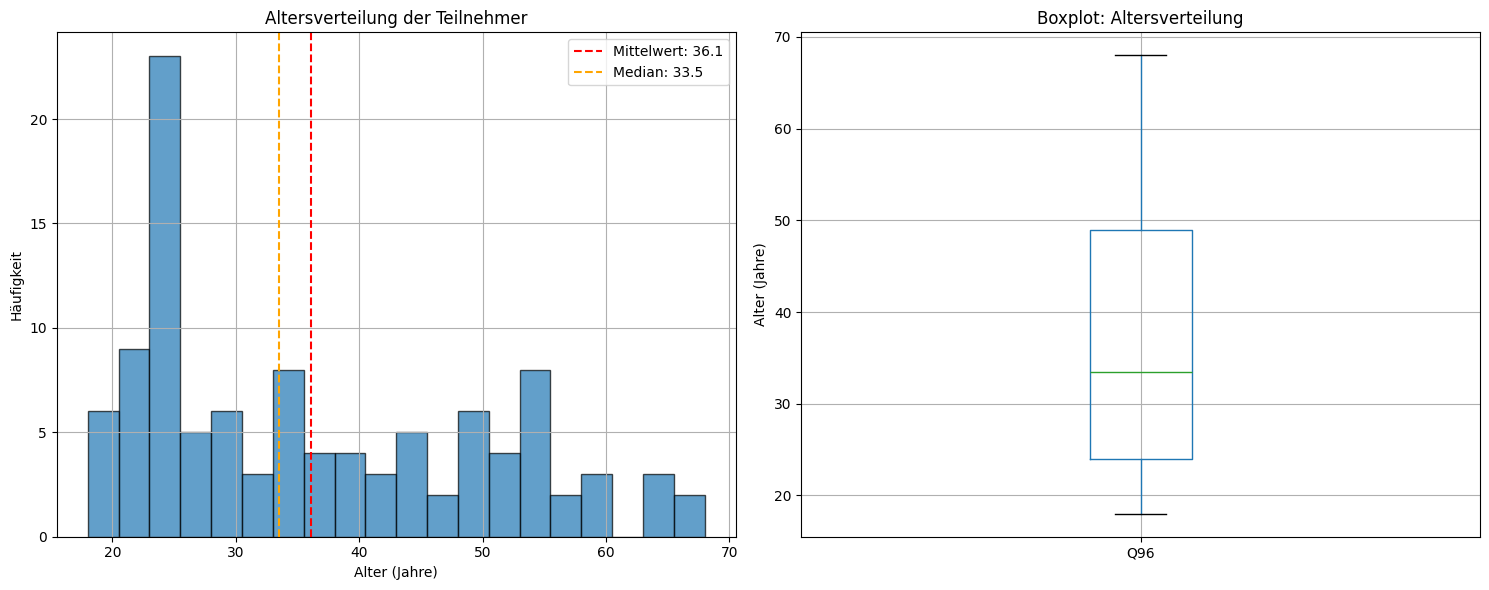

<Figure size 1000x600 with 0 Axes>

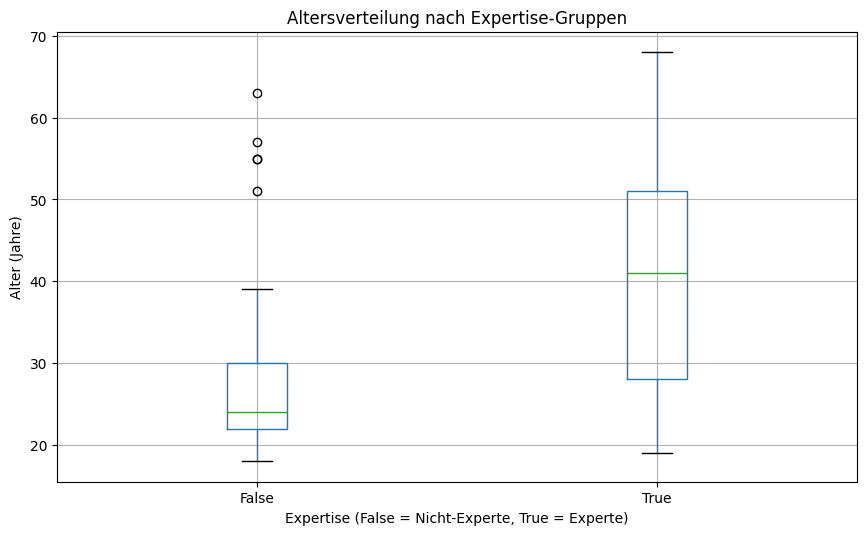

In [106]:
q_set = get_q_columns_from_v(['v_142'], inverse_map)
alter_column = list(q_set)[0] if q_set else 'v_142'
combined_df['alter'] = combined_df[alter_column]


# print(combined_df[alter_column].describe())


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

combined_df[alter_column].hist(bins=20, ax=ax1, edgecolor='black', alpha=0.7)
ax1.set_title('Altersverteilung der Teilnehmer')
ax1.set_xlabel('Alter (Jahre)')
ax1.set_ylabel('Häufigkeit')
ax1.axvline(combined_df[alter_column].mean(), color='red', linestyle='--', 
            label=f'Mittelwert: {combined_df[alter_column].mean():.1f}')
ax1.axvline(combined_df[alter_column].median(), color='orange', linestyle='--', 
            label=f'Median: {combined_df[alter_column].median():.1f}')
ax1.legend()

combined_df.boxplot(column=alter_column, ax=ax2)
ax2.set_title('Boxplot: Altersverteilung')
ax2.set_ylabel('Alter (Jahre)')

plt.tight_layout()
plt.show()

alter_by_expertise = combined_df.groupby('is_professional')[alter_column].describe()

plt.figure(figsize=(10, 6))
combined_df.boxplot(column=alter_column, by='is_professional', figsize=(10, 6))
plt.title('Altersverteilung nach Expertise-Gruppen')
plt.xlabel('Expertise (False = Nicht-Experte, True = Experte)')
plt.ylabel('Alter (Jahre)')
plt.suptitle('') 
plt.show()

#### Geschlecht

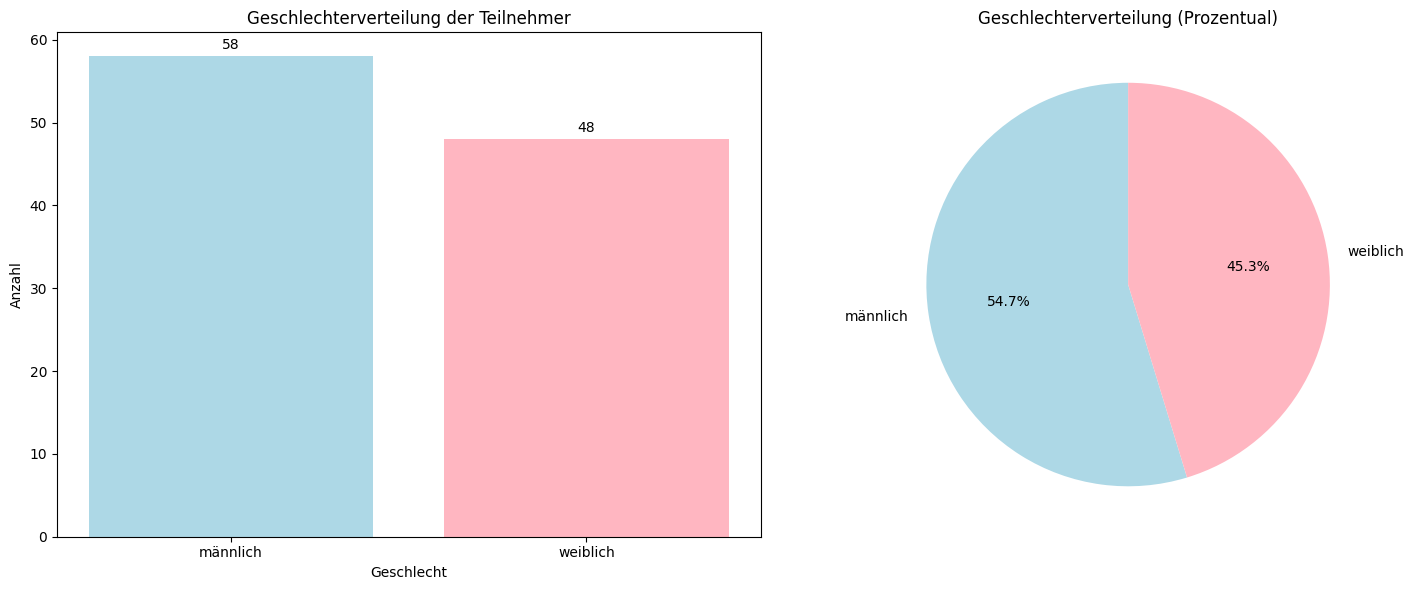

<Figure size 1000x600 with 0 Axes>

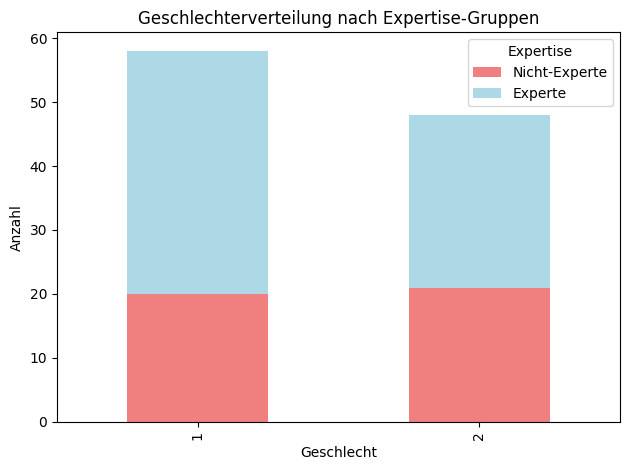

In [107]:
q_set = get_q_columns_from_v(['v_141'], inverse_map) 
geschlecht_column = list(q_set)[0] if q_set else 'v_geschlecht'
combined_df['geschlecht'] = combined_df[geschlecht_column]

geschlecht_mapping = {1: 'männlich', 2: 'weiblich', 3: 'divers'}

geschlecht_counts = combined_df[geschlecht_column].value_counts().sort_index()
geschlecht_percent = combined_df[geschlecht_column].value_counts(normalize=True).sort_index() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

geschlecht_labels = [geschlecht_mapping.get(idx, f'Kategorie {idx}') for idx in geschlecht_counts.index]
bars = ax1.bar(geschlecht_labels, geschlecht_counts.values, color=['lightblue', 'lightpink', 'lightgreen'])
ax1.set_title('Geschlechterverteilung der Teilnehmer')
ax1.set_xlabel('Geschlecht')
ax1.set_ylabel('Anzahl')

for bar, count in zip(bars, geschlecht_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom')

ax2.pie(geschlecht_counts.values, labels=geschlecht_labels, autopct='%1.1f%%', 
        colors=['lightblue', 'lightpink', 'lightgreen'], startangle=90)
ax2.set_title('Geschlechterverteilung (Prozentual)')

plt.tight_layout()
plt.show()

geschlecht_expertise = pd.crosstab(combined_df[geschlecht_column], combined_df['is_professional'], 
                                   margins=True, normalize='columns') * 100

expertise_labels = ['Nicht-Experte', 'Experte']
geschlecht_by_expertise = pd.crosstab(combined_df[geschlecht_column], combined_df['is_professional'])

plt.figure(figsize=(10, 6))
geschlecht_by_expertise.plot(kind='bar', stacked=True, color=['lightcoral', 'lightblue'])
plt.title('Geschlechterverteilung nach Expertise-Gruppen')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.legend(expertise_labels, title='Expertise')
# plt.xticks([0, 1, 2], geschlecht_labels, rotation=0)
plt.tight_layout()
plt.show()

#### Beruf

In [108]:
q_set = get_q_columns_from_v(['v_228'], inverse_map)  
beruf_column = list(q_set)[0] if q_set else 'v_beruf'
combined_df['berufserfahrung'] = combined_df[beruf_column]


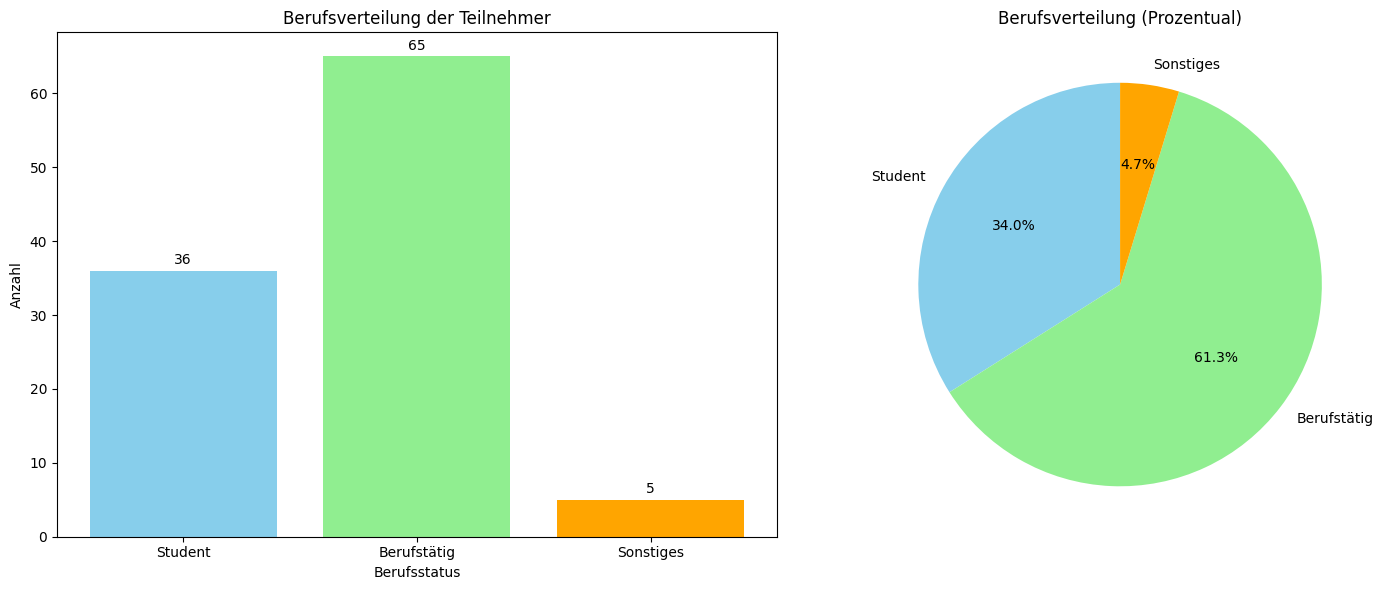

<Figure size 1000x600 with 0 Axes>

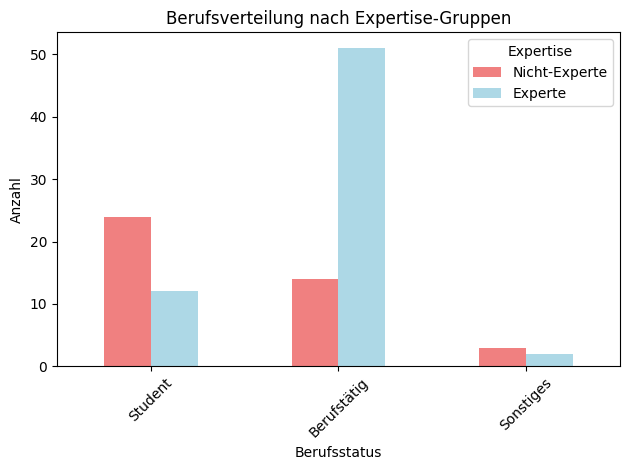

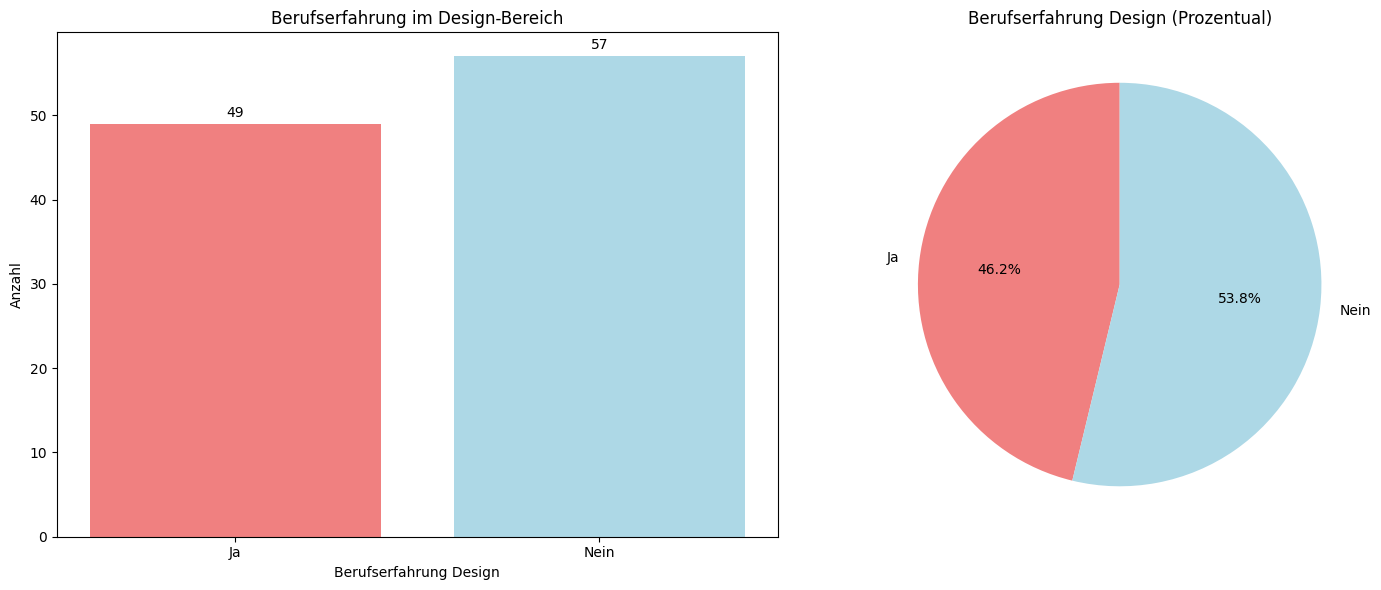

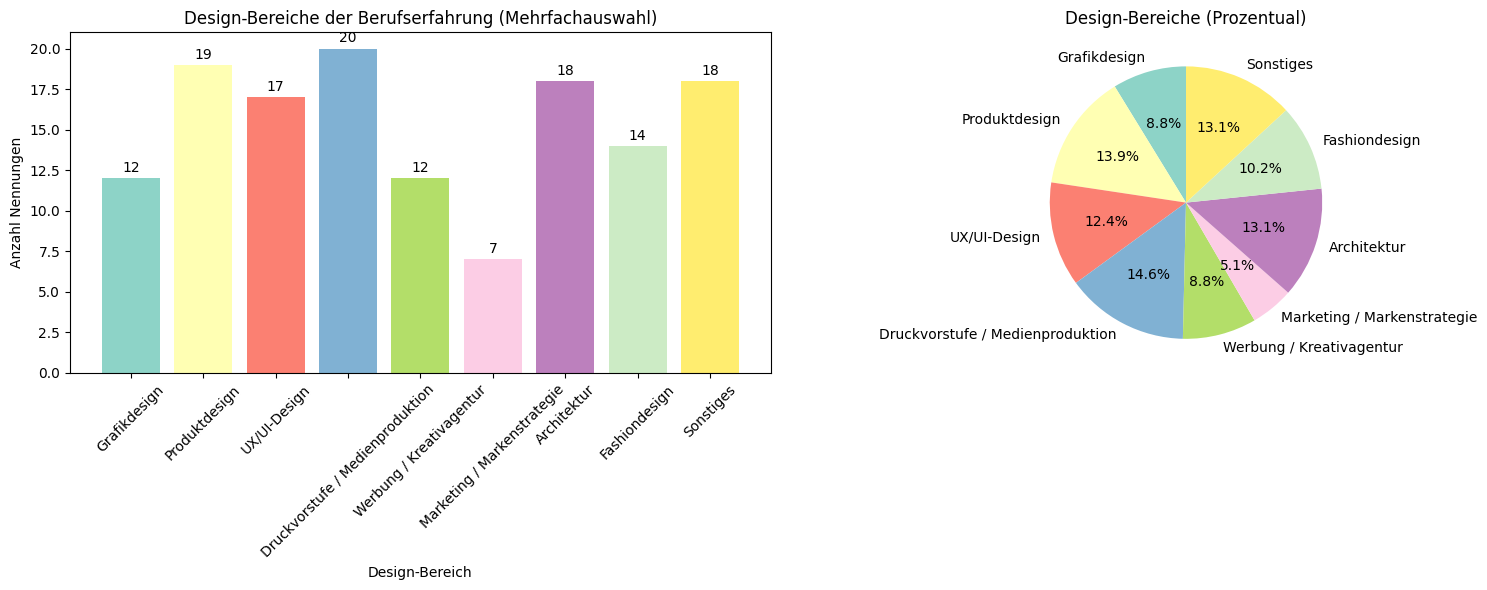

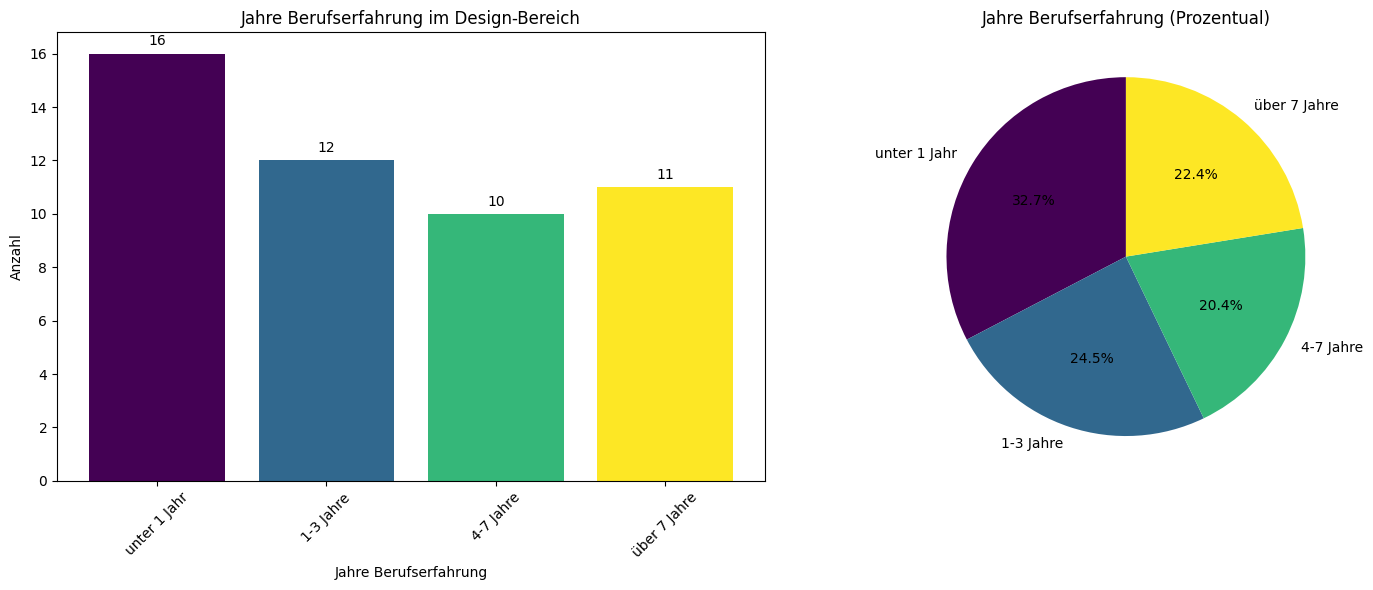

<Figure size 1000x600 with 0 Axes>

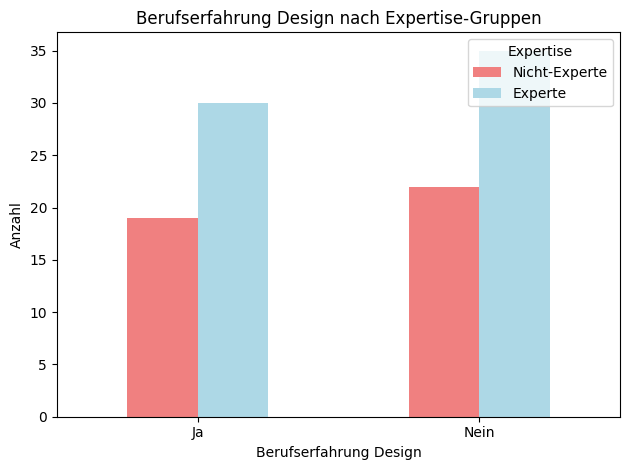

<Figure size 1200x600 with 0 Axes>

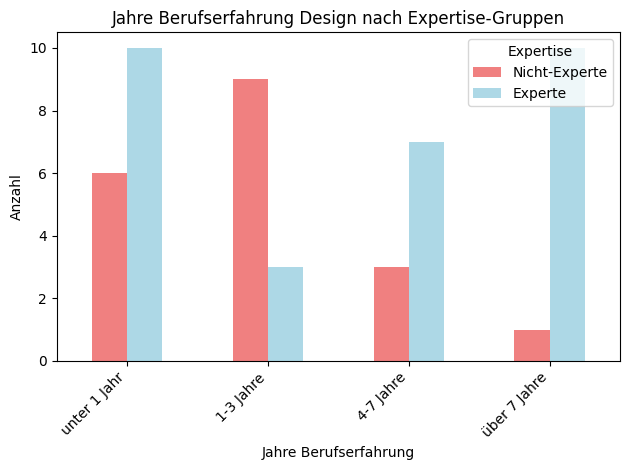

In [109]:
q_set = get_q_columns_from_v(['v_140'], inverse_map)  
beruf_column = list(q_set)[0] if q_set else 'v_beruf'  

beruf_mapping = {1: 'Student', 2: 'Berufstätig', 3: 'Sonstiges'}

beruf_counts = combined_df[beruf_column].value_counts().sort_index()
beruf_percent = combined_df[beruf_column].value_counts(normalize=True).sort_index() * 100


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

beruf_labels = [beruf_mapping.get(idx, f'Kategorie {idx}') for idx in beruf_counts.index]
bars = ax1.bar(beruf_labels, beruf_counts.values, color=['skyblue', 'lightgreen', 'orange'])
ax1.set_title('Berufsverteilung der Teilnehmer')
ax1.set_xlabel('Berufsstatus')
ax1.set_ylabel('Anzahl')

for bar, count in zip(bars, beruf_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom')

ax2.pie(beruf_counts.values, labels=beruf_labels, autopct='%1.1f%%', 
        colors=['skyblue', 'lightgreen', 'orange'], startangle=90)
ax2.set_title('Berufsverteilung (Prozentual)')

plt.tight_layout()
plt.show()

beruf_expertise = pd.crosstab(combined_df[beruf_column], combined_df['is_professional'], 
                              margins=True, normalize='columns') * 100

beruf_by_expertise = pd.crosstab(combined_df[beruf_column], combined_df['is_professional'])

plt.figure(figsize=(10, 6))
beruf_by_expertise.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Berufsverteilung nach Expertise-Gruppen')
plt.xlabel('Berufsstatus')
plt.ylabel('Anzahl')
plt.legend(['Nicht-Experte', 'Experte'], title='Expertise')
plt.xticks(range(len(beruf_labels)), beruf_labels, rotation=45)
plt.tight_layout()
plt.show()


design_erfahrung_column = 'v_11423'
design_erfahrung_mapping = {1: 'Ja', 2: 'Nein'}

design_bereiche_columns = ['v_11424', 'v_11425', 'v_11426', 
                          'v_11427', 'v_11428','v_11429', 'v_11430','v_11431', 'v_11432']  
bereiche_mapping = {
    'v_11424': 'Grafikdesign',
    'v_11425': 'Produktdesign',
    'v_11426': 'UX/UI-Design',
    'v_11427': 'Druckvorstufe / Medienproduktion',
    'v_11428': 'Werbung / Kreativagentur',
    'v_11429': 'Marketing / Markenstrategie',
    'v_11430': 'Architektur',
    'v_11431': 'Fashiondesign',
    'v_11432': 'Sonstiges',
}

design_jahre_column = 'v_11435'
design_jahre_mapping = {
    1: 'unter 1 Jahr',
    2: '1-3 Jahre', 
    3: '4-7 Jahre',
    4: 'über 7 Jahre'
}



np.random.seed(42)
n_participants = len(combined_df)
combined_df[design_erfahrung_column] = np.random.choice([1, 2], n_participants, p=[0.4, 0.6])

for col in design_bereiche_columns:
    combined_df[col] = np.where(combined_df[design_erfahrung_column] == 1, 
                                np.random.choice([0, 1], n_participants, p=[0.7, 0.3]), 0)

combined_df[design_jahre_column] = np.where(combined_df[design_erfahrung_column] == 1,
                                           np.random.choice([1, 2, 3, 4], n_participants, p=[0.3, 0.3, 0.25, 0.15]),
                                           np.nan)


design_erfahrung_counts = combined_df[design_erfahrung_column].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

design_erfahrung_labels = [design_erfahrung_mapping.get(idx, f'Kategorie {idx}') 
                          for idx in design_erfahrung_counts.index]
bars = ax1.bar(design_erfahrung_labels, design_erfahrung_counts.values, 
               color=['lightcoral', 'lightblue'])
ax1.set_title('Berufserfahrung im Design-Bereich')
ax1.set_xlabel('Berufserfahrung Design')
ax1.set_ylabel('Anzahl')

for bar, count in zip(bars, design_erfahrung_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom')

ax2.pie(design_erfahrung_counts.values, labels=design_erfahrung_labels, autopct='%1.1f%%', 
        colors=['lightcoral', 'lightblue'], startangle=90)
ax2.set_title('Berufserfahrung Design (Prozentual)')

plt.tight_layout()
plt.show()

design_experienced = combined_df[combined_df[design_erfahrung_column] == 1]

if len(design_experienced) > 0:
    bereich_counts = {}
    for col in design_bereiche_columns:
        bereich_name = bereiche_mapping[col]
        bereich_counts[bereich_name] = design_experienced[col].sum()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    bereiche_names = list(bereich_counts.keys())
    bereiche_values = list(bereich_counts.values())
    
    bars = ax1.bar(bereiche_names, bereiche_values, color=plt.cm.Set3(np.linspace(0, 1, len(bereiche_names))))
    ax1.set_title('Design-Bereiche der Berufserfahrung (Mehrfachauswahl)')
    ax1.set_xlabel('Design-Bereich')
    ax1.set_ylabel('Anzahl Nennungen')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, count in zip(bars, bereiche_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                 str(count), ha='center', va='bottom')

    bereiche_percent = [(count/len(design_experienced))*100 for count in bereiche_values]
    ax2.pie(bereiche_values, labels=bereiche_names, autopct='%1.1f%%', 
            colors=plt.cm.Set3(np.linspace(0, 1, len(bereiche_names))), startangle=90)
    ax2.set_title('Design-Bereiche (Prozentual)')
    
    plt.tight_layout()
    plt.show()

if len(design_experienced) > 0:
    design_jahre_counts = design_experienced[design_jahre_column].value_counts().sort_index()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    design_jahre_labels = [design_jahre_mapping.get(idx, f'Kategorie {idx}') 
                          for idx in design_jahre_counts.index]
    bars = ax1.bar(design_jahre_labels, design_jahre_counts.values, 
                   color=plt.cm.viridis(np.linspace(0, 1, len(design_jahre_labels))))
    ax1.set_title('Jahre Berufserfahrung im Design-Bereich')
    ax1.set_xlabel('Jahre Berufserfahrung')
    ax1.set_ylabel('Anzahl')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar, count in zip(bars, design_jahre_counts.values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                 str(count), ha='center', va='bottom')
    
    ax2.pie(design_jahre_counts.values, labels=design_jahre_labels, autopct='%1.1f%%', 
            colors=plt.cm.viridis(np.linspace(0, 1, len(design_jahre_labels))), startangle=90)
    ax2.set_title('Jahre Berufserfahrung (Prozentual)')
    
    plt.tight_layout()
    plt.show()

design_by_expertise = pd.crosstab(combined_df[design_erfahrung_column], 
                                 combined_df['is_professional'])

plt.figure(figsize=(10, 6))
design_by_expertise.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Berufserfahrung Design nach Expertise-Gruppen')
plt.xlabel('Berufserfahrung Design')
plt.ylabel('Anzahl')
plt.legend(['Nicht-Experte', 'Experte'], title='Expertise')
plt.xticks([0, 1], design_erfahrung_labels, rotation=0)
plt.tight_layout()
plt.show()

if len(design_experienced) > 0:
    design_jahre_by_expertise = pd.crosstab(design_experienced[design_jahre_column], 
                                           design_experienced['is_professional'])
    
    plt.figure(figsize=(12, 6))
    design_jahre_by_expertise.plot(kind='bar', color=['lightcoral', 'lightblue'])
    plt.title('Jahre Berufserfahrung Design nach Expertise-Gruppen')
    plt.xlabel('Jahre Berufserfahrung')
    plt.ylabel('Anzahl')
    plt.legend(['Nicht-Experte', 'Experte'], title='Expertise')
    plt.xticks(range(len(design_jahre_labels)), design_jahre_labels, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### Einkommen

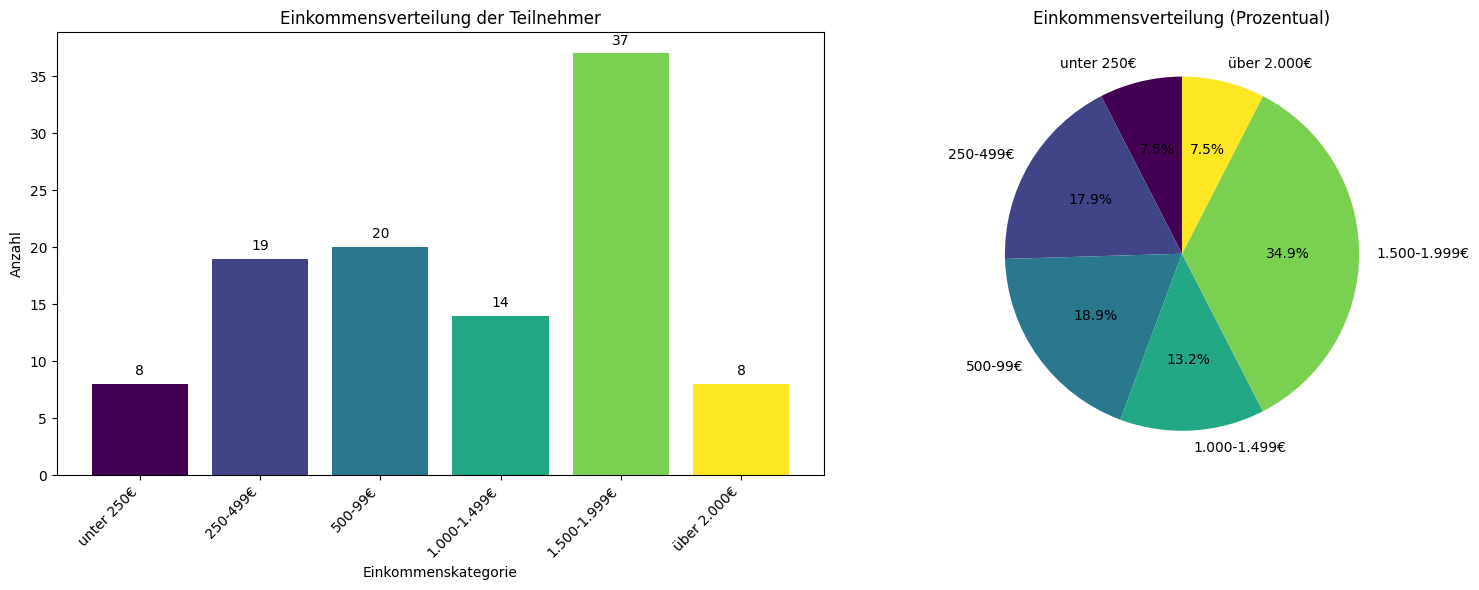

<Figure size 1200x600 with 0 Axes>

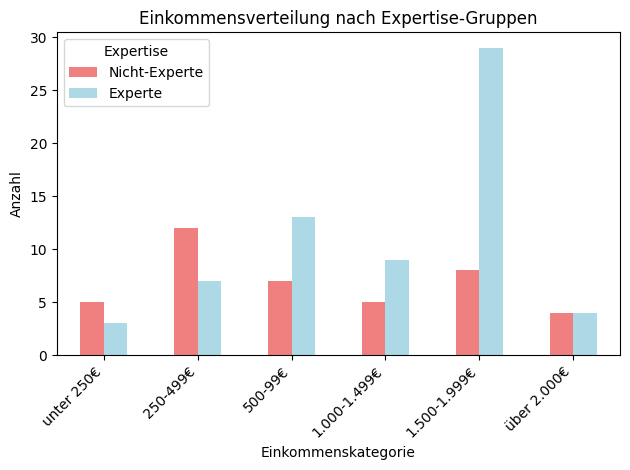

In [110]:
q_set = get_q_columns_from_v(['v_139'], inverse_map)  
einkommen_column = list(q_set)[0] if q_set else 'v_einkommen' 
combined_df['einkommen'] = combined_df[einkommen_column]

einkommen_mapping = {
    1: 'unter 250€',
    2: '250-499€',
    3: '500-99€',
    4: '1.000-1.499€',
    5: '1.500-1.999€',
    6: 'über 2.000€'
}


einkommen_counts = combined_df[einkommen_column].value_counts().sort_index()
einkommen_percent = combined_df[einkommen_column].value_counts(normalize=True).sort_index() * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

einkommen_labels = [einkommen_mapping.get(idx, f'Kategorie {idx}') for idx in einkommen_counts.index]
bars = ax1.bar(range(len(einkommen_labels)), einkommen_counts.values, 
               color=plt.cm.viridis(np.linspace(0, 1, len(einkommen_labels))))
ax1.set_title('Einkommensverteilung der Teilnehmer')
ax1.set_xlabel('Einkommenskategorie')
ax1.set_ylabel('Anzahl')
ax1.set_xticks(range(len(einkommen_labels)))
ax1.set_xticklabels(einkommen_labels, rotation=45, ha='right')

for bar, count in zip(bars, einkommen_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom')

colors = plt.cm.viridis(np.linspace(0, 1, len(einkommen_labels)))
ax2.pie(einkommen_counts.values, labels=einkommen_labels, autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Einkommensverteilung (Prozentual)')

plt.tight_layout()
plt.show()

einkommen_expertise = pd.crosstab(combined_df[einkommen_column], combined_df['is_professional'], 
                                  margins=True, normalize='columns') * 100


einkommen_by_expertise = pd.crosstab(combined_df[einkommen_column], combined_df['is_professional'])

plt.figure(figsize=(12, 6))
einkommen_by_expertise.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Einkommensverteilung nach Expertise-Gruppen')
plt.xlabel('Einkommenskategorie')
plt.ylabel('Anzahl')
plt.legend(['Nicht-Experte', 'Experte'], title='Expertise')
plt.xticks(range(len(einkommen_labels)), einkommen_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Stilzuordnung

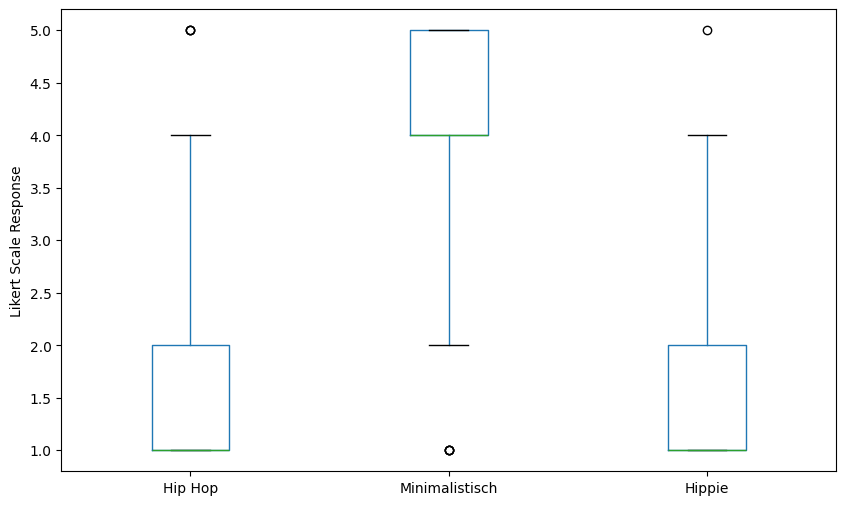

In [136]:
stlye_columns = get_q_columns_from_v(['v_11040', 'v_11041', 'v_11042'], inverse_map)
columns_to_analyze = list(stlye_columns)

plt.figure(figsize=(10, 6))
combined_df[columns_to_analyze].boxplot(grid=False, figsize=(10, 6), whis=[5,95])
# plt.title('Stilzuordnung')
plt.xlabel('')
plt.xticks([1,2,3],['Hip Hop', 'Minimalistisch', 'Hippie'])
plt.ylabel('Likert Scale Response')
plt.suptitle('')
plt.show()

In [112]:
style_means = combined_df[columns_to_analyze].mean()
style_means

Q95    1.867925
Q93    3.933962
Q94    1.688679
dtype: float64

### Wahrgenommene Konsistenz

In [113]:
konsistenz_columns = get_q_columns_from_v(['v_11037', 'v_11038', 'v_11039'], inverse_map)
columns_to_analyze = list(konsistenz_columns)
analyze_construct_reliability(combined_df, columns_to_analyze, 'Wahrgenommene Konsistenz')

Anzahl Items: 3
Gültige Fälle: 106 von 106
Cronbach's α = 0.873 (Gut)

Item-Statistiken:
  Q91: M = 3.99, SD = 1.14
  Q90: M = 4.27, SD = 1.11
  Q92: M = 3.74, SD = 1.15

Inter-Item-Korrelationen:
  Durchschnitt: 0.696
  Bereich: [0.581, 0.782]

Cronbach's α wenn Item entfernt:
  ohne Q91: α = 0.734 (Δ = -0.139)
  ohne Q90: α = 0.878 (Δ = +0.005)
  ohne Q92: α = 0.840 (Δ = -0.033)


{'alpha': np.float64(0.8729436301263059),
 'evaluation': 'Gut',
 'n_items': 3,
 'n_cases': 106,
 'available_columns': ['Q91', 'Q90', 'Q92']}

In [114]:
combined_df['consistency_mean'] = combined_df[columns_to_analyze].mean(axis=1)

priming1 = combined_df[combined_df['is_consistent'] == False]
priming3 = combined_df[combined_df['is_consistent'] == True]

t_stat, p_value = ttest_ind(priming1['consistency_mean'], priming3['consistency_mean'], equal_var=True)
summarize_ttest(t_stat, p_value, 'ansprechend', 'konsistent')

t-Test (ansprechend vs. konsistent): t = -2.703, p = 0.008, signifikant.
(α = 0.05)


In [115]:
# Define the groups for comparison
priming1 = combined_df[combined_df['is_consistent'] == True]['consistency_mean'].dropna()
priming3 = combined_df[combined_df['is_consistent'] == False]['consistency_mean'].dropna()

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(priming1, priming3, alternative='two-sided')

print(f"Mann-Whitney-U-Test (ansprechend vs. konsistent): U = {statistic:.0f}, p = {p_value:.4f}")

Mann-Whitney-U-Test (ansprechend vs. konsistent): U = 1776, p = 0.0167


<Figure size 1000x600 with 0 Axes>

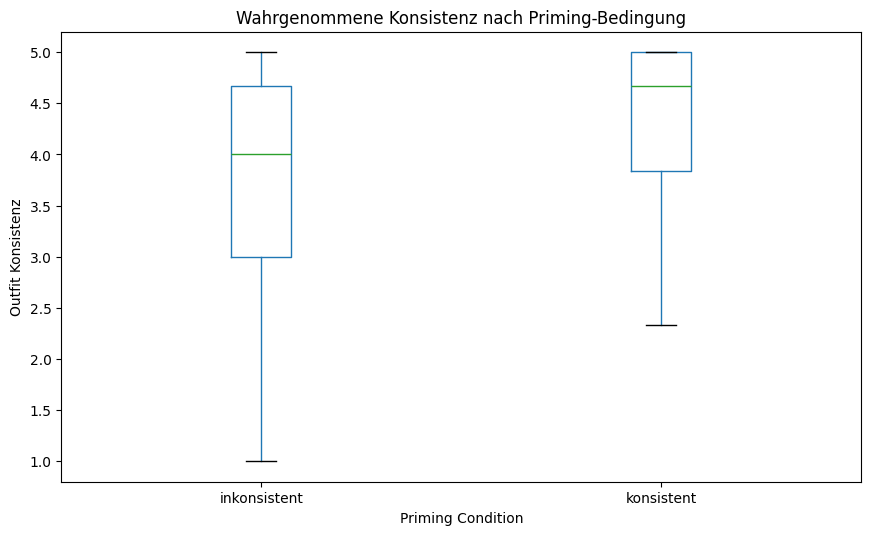

In [138]:
plt.figure(figsize=(10, 6))
combined_df.boxplot(column='consistency_mean', by='priming', grid=False, figsize=(10, 6), whis=[0,100])
plt.title('Wahrgenommene Konsistenz nach Priming-Bedingung')
plt.xlabel('Priming Condition')
plt.ylabel('Outfit Konsistenz')
plt.xticks([1,2],['inkonsistent', 'konsistent' ])
plt.suptitle('')  # clear the automatic suptitle
plt.show()

In [117]:
combined_df.head()

,priming,is_professional,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,v_11426,v_11427,v_11428,v_11429,v_11430,v_11431,v_11432,v_11435,einkommen,consistency_mean
0,3,True,2,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,4.0,4,4.000000
1,1,True,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,5,4.666667
2,1,True,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,NaN,3,4.333333
3,3,True,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,NaN,4,5.000000
4,1,False,1,1,1,1,1,0,1,0,...,0,0,1,0,0,0,0,2.0,2,2.666667


#### Vorraussetzungen

#### Reliabilitätsanalyse Liking-Konstrukt

In [118]:
liking_columns = ['v_10959','v_10960','v_10961']
liking_q = list(get_q_columns_from_v(liking_columns, inverse_map))

if liking_q:
    analyze_construct_reliability(combined_df, liking_q, "Liking Gesamt")

Anzahl Items: 3
Gültige Fälle: 106 von 106
Cronbach's α = 0.949 (Exzellent)

Item-Statistiken:
  Q78: M = 3.02, SD = 1.08
  Q77: M = 3.15, SD = 1.04
  Q79: M = 3.16, SD = 1.19

Inter-Item-Korrelationen:
  Durchschnitt: 0.867
  Bereich: [0.859, 0.881]

Cronbach's α wenn Item entfernt:
  ohne Q78: α = 0.920 (Δ = -0.030)
  ohne Q77: α = 0.922 (Δ = -0.027)
  ohne Q79: α = 0.936 (Δ = -0.013)


In [119]:
q_set = get_q_columns_from_v(liking_columns, inverse_map)
columns_to_analyze = list(q_set)
combined_df['mean_liking'] = combined_df[columns_to_analyze].mean(axis=1)

for prim in combined_df['priming'].unique():
    for prof in [True, False]:
        grp = combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['mean_liking']
        if len(grp) >= 3:
            W, p = shapiro(grp)
            print(f"Shapiro prim={prim}, prof={prof}: W={W:.3f}, p={p:.4f}")

Shapiro prim=3, prof=True: W=0.941, p=0.0676
Shapiro prim=3, prof=False: W=0.854, p=0.0123
Shapiro prim=1, prof=True: W=0.946, p=0.1235
Shapiro prim=1, prof=False: W=0.941, p=0.1686


In [120]:
groups = [
    combined_df[(combined_df['priming']==prim) & (combined_df['is_professional']==prof)]['mean_liking']
    for prim in combined_df['priming'].unique() 
    for prof in [True, False]
]
W_le, p_le = levene(*groups)
print(f"\nLevene-Test: W={W_le:.3f}, p={p_le:.4f}")


Levene-Test: W=0.623, p=0.6019


#### T-test

In [121]:
experts_liking = combined_df[combined_df['is_professional'] == True]['mean_liking']
non_experts_liking = combined_df[combined_df['is_professional'] == False]['mean_liking']

t_stat_h1, p_value_h1 = ttest_ind(experts_liking, non_experts_liking, equal_var=False)

print(f"Experten (n={len(experts_liking)}): M={experts_liking.mean():.3f}, SD={experts_liking.std():.3f}")
print(f"Nicht-Experten (n={len(non_experts_liking)}): M={non_experts_liking.mean():.3f}, SD={non_experts_liking.std():.3f}")
summarize_ttest(t_stat_h1, p_value_h1, "Experten", "Nicht-Experten")
print()

Experten (n=65): M=3.215, SD=0.955
Nicht-Experten (n=41): M=2.943, SD=1.183
t-Test (Experten vs. Nicht-Experten): t = 1.241, p = 0.219, nicht signifikant.
(α = 0.05)



In [122]:
priming1 = combined_df[combined_df['priming'] == 1]['mean_liking']
priming3 = combined_df[combined_df['priming'] == 3]['mean_liking']

t_stat_h1, p_value_h1 = ttest_ind(priming1,  priming3, equal_var=False)

print(f"Priming inkonsistent (ansprechend) (n={len(priming1)}): M={priming1.mean():.3f}, SD={priming1.std():.3f}")
print(f"Priming konsistent (n={len(priming3)}): M={priming3.mean():.3f}, SD={priming3.std():.3f}")

summarize_ttest(t_stat_h1, p_value_h1, "Priming inkonsistent", "Priming konsistent")
print()

Priming inkonsistent (ansprechend) (n=55): M=3.121, SD=1.066
Priming konsistent (n=51): M=3.098, SD=1.046
t-Test (Priming inkonsistent vs. Priming konsistent): t = 0.113, p = 0.910, nicht signifikant.
(α = 0.05)



### Hypothese

#### Vorraussetzungen

In [123]:
price_columns = ['v_10902', 'v_10911', 'v_10920', 'v_10929', 'v_10938', 'v_10947' ]
q_set = get_q_columns_from_v(price_columns, inverse_map)
columns_to_analyze = list(q_set)
combined_df['outfit_sum'] = combined_df[columns_to_analyze].sum(axis=1)


In [124]:
price_columns = ['v_11376']
q_set = get_q_columns_from_v(price_columns, inverse_map)
columns_to_analyze = list(q_set)
combined_df['outfit_sum'] = combined_df[columns_to_analyze]


In [125]:
for prim in combined_df['is_consistent'].unique():
    for prof in [True, False]:
        grp = combined_df[(combined_df['is_consistent']==prim) & (combined_df['is_professional']==prof)]['outfit_sum']
        if len(grp) >= 3:
            W, p = shapiro(grp)
            print(f"Shapiro consistent={prim}, prof={prof}: W={W:.3f}, p={p:.4f} N={len(grp)}")

Shapiro consistent=True, prof=True: W=0.781, p=0.0000 N=34
Shapiro consistent=True, prof=False: W=0.944, p=0.3655 N=17
Shapiro consistent=False, prof=True: W=0.723, p=0.0000 N=31
Shapiro consistent=False, prof=False: W=0.793, p=0.0002 N=24


In [126]:
groups = [
    combined_df[(combined_df['is_consistent']==prim) & (combined_df['is_professional']==prof)]['outfit_sum']
    for prim in combined_df['is_consistent'].unique() 
    for prof in [True, False]
]
W_le, p_le = levene(*groups)
print(f"\nLevene-Test: W={W_le:.3f}, p={p_le:.4f}")


Levene-Test: W=2.047, p=0.1120


In [127]:
# Mann-Whitney-U Test für Expertise-Effekt
experts_price = combined_df[combined_df['is_professional'] == True]['outfit_sum']
non_experts_price = combined_df[combined_df['is_professional'] == False]['outfit_sum']

statistic, p_value = mannwhitneyu(experts_price, non_experts_price, alternative='two-sided')
print(f"\nExpertise-Effekt (Mann-Whitney-U):")
print(f"   U = {statistic:.0f}, p = {p_value:.4f}")
print(f"   Experten: Median = {experts_price.median():.1f}, n = {len(experts_price)}")
print(f"   Nicht-Experten: Median = {non_experts_price.median():.1f}, n = {len(non_experts_price)}")

# Mann-Whitney-U Test für Konsistenz-Effekt  
consistent_price = combined_df[combined_df['is_consistent'] == True]['outfit_sum']
inconsistent_price = combined_df[combined_df['is_consistent'] == False]['outfit_sum']

statistic, p_value = mannwhitneyu(consistent_price, inconsistent_price, alternative='two-sided')
print(f"\nKonsistenz-Effekt (Mann-Whitney-U):")
print(f"   U = {statistic:.0f}, p = {p_value:.4f}")
print(f"   Konsistent: Median = {consistent_price.median():.1f}, n = {len(consistent_price)}")
print(f"   Inkonsistent: Median = {inconsistent_price.median():.1f}, n = {len(inconsistent_price)}")

# Erstelle Gruppierungsvariable für alle 4 Kombinationen
combined_df['group_combination'] = combined_df['is_consistent'].astype(str) + '_' + combined_df['is_professional'].astype(str)

groups_kw = []
group_names = []
for combo in combined_df['group_combination'].unique():
    group_data = combined_df[combined_df['group_combination'] == combo]['outfit_sum']
    groups_kw.append(group_data)
    group_names.append(combo)

# Kruskal-Wallis Test
h_statistic, p_value = kruskal(*groups_kw)
print(f"\nKruskal-Wallis-Test (alle Gruppen):")
print(f"   H = {h_statistic:.3f}, p = {p_value:.4f}")

# Deskriptive Statistiken für alle Gruppen
print(f"\nGruppen-Mediane:")
for i, name in enumerate(group_names):
    median_val = groups_kw[i].median()
    n_val = len(groups_kw[i])
    print(f"   {name}: Median = {median_val:.1f}, n = {n_val}")


def bootstrap_mean_diff(group1, group2, n_bootstrap=1000):
    """Bootstrap-Konfidenzintervall für Mittelwertdifferenz"""
    np.random.seed(42)
    bootstrap_diffs = []
    
    for _ in range(n_bootstrap):
        # Bootstrap-Stichproben ziehen
        boot_group1 = np.random.choice(group1, size=len(group1), replace=True)
        boot_group2 = np.random.choice(group2, size=len(group2), replace=True)
        
        # Differenz berechnen
        diff = np.mean(boot_group1) - np.mean(boot_group2)
        bootstrap_diffs.append(diff)
    
    # Konfidenzintervall berechnen (95%)
    ci_lower = np.percentile(bootstrap_diffs, 2.5)
    ci_upper = np.percentile(bootstrap_diffs, 97.5)
    
    return bootstrap_diffs, ci_lower, ci_upper

# Bootstrap für Expertise-Effekt
boot_diffs, ci_lower, ci_upper = bootstrap_mean_diff(experts_price, non_experts_price)
observed_diff = experts_price.mean() - non_experts_price.mean()

print(f"\nBootstrap-Konfidenzintervall (Expertise-Effekt):")
print(f"   Beobachtete Differenz: {observed_diff:.1f}")
print(f"   95% KI: [{ci_lower:.1f}, {ci_upper:.1f}]")
print(f"   {'Signifikant' if 0 < ci_lower or 0 > ci_upper else 'Nicht signifikant'} (KI schließt 0 {'nicht ' if 0 < ci_lower or 0 > ci_upper else ''}ein)")

# Bootstrap für Konsistenz-Effekt
boot_diffs, ci_lower, ci_upper = bootstrap_mean_diff(consistent_price, inconsistent_price)
observed_diff = consistent_price.mean() - inconsistent_price.mean()

print(f"\nBootstrap-Konfidenzintervall (Konsistenz-Effekt):")
print(f"   Beobachtete Differenz: {observed_diff:.1f}")  
print(f"   95% KI: [{ci_lower:.1f}, {ci_upper:.1f}]")
print(f"   {'Signifikant' if 0 < ci_lower or 0 > ci_upper else 'Nicht signifikant'} (KI schließt 0 {'nicht ' if 0 < ci_lower or 0 > ci_upper else ''}ein)")


Expertise-Effekt (Mann-Whitney-U):
   U = 1762, p = 0.0054
   Experten: Median = 960.0, n = 65
   Nicht-Experten: Median = 620.0, n = 41

Konsistenz-Effekt (Mann-Whitney-U):
   U = 1519, p = 0.4632
   Konsistent: Median = 960.0, n = 51
   Inkonsistent: Median = 741.0, n = 55

Kruskal-Wallis-Test (alle Gruppen):
   H = 8.478, p = 0.0371

Gruppen-Mediane:
   True_True: Median = 1027.5, n = 34
   False_True: Median = 865.0, n = 31
   False_False: Median = 572.5, n = 24
   True_False: Median = 810.0, n = 17

Bootstrap-Konfidenzintervall (Expertise-Effekt):
   Beobachtete Differenz: 575.0
   95% KI: [264.9, 925.9]
   Signifikant (KI schließt 0 nicht ein)

Bootstrap-Konfidenzintervall (Konsistenz-Effekt):
   Beobachtete Differenz: 57.0
   95% KI: [-346.3, 459.3]
   Nicht signifikant (KI schließt 0 ein)


#### T-test

In [128]:
experts_price = combined_df[combined_df['is_professional'] == True]['outfit_sum']
non_experts_price = combined_df[combined_df['is_professional'] == False]['outfit_sum']

t_stat_h2, p_value_h2 = ttest_ind(experts_price, non_experts_price, equal_var=False)

print(f"Experten (n={len(experts_price)}): M={experts_price.mean():.3f}, SD={experts_price.std():.3f}")
print(f"Nicht-Experten (n={len(non_experts_price)}): M={non_experts_price.mean():.3f}, SD={non_experts_price.std():.3f}")
summarize_ttest(t_stat_h2, p_value_h2, "Experten", "Nicht-Experten")
print()

Experten (n=65): M=1373.000, SD=1199.945
Nicht-Experten (n=41): M=798.024, SD=483.118
t-Test (Experten vs. Nicht-Experten): t = 3.446, p = 0.001, signifikant.
(α = 0.05)



In [129]:
priming1 = combined_df[combined_df['priming'] == 1]['outfit_sum']
priming3 = combined_df[combined_df['priming'] == 3]['outfit_sum']

t_stat_h2, p_value_h2 = ttest_ind(priming1, priming3, equal_var=False)

print(f"Priming inkonsistent (ansprechend) (n={len(priming1)}): M={priming1.mean():.3f}, SD={priming1.std():.3f}")
print(f"Priming konsistent (n={len(priming3)}): M={priming3.mean():.3f}, SD={priming3.std():.3f}")

summarize_ttest(t_stat_h2, p_value_h2, "Priming inkonsistent", "Priming konsistent")
print()


Priming inkonsistent (ansprechend) (n=55): M=1123.200, SD=1046.575
Priming konsistent (n=51): M=1180.157, SD=1005.647
t-Test (Priming inkonsistent vs. Priming konsistent): t = -0.286, p = 0.776, nicht signifikant.
(α = 0.05)



#### Regressionsanalyse

In [130]:
model = rlm('outfit_sum ~ C(is_consistent) * C(is_professional) ', data=combined_df).fit()
print(model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:             outfit_sum   No. Observations:                  106
Model:                            RLM   Df Residuals:                      102
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 14 Aug 2025                                         
Time:                        23:09:20                                         
No. Iterations:                    12                                         
                                                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------

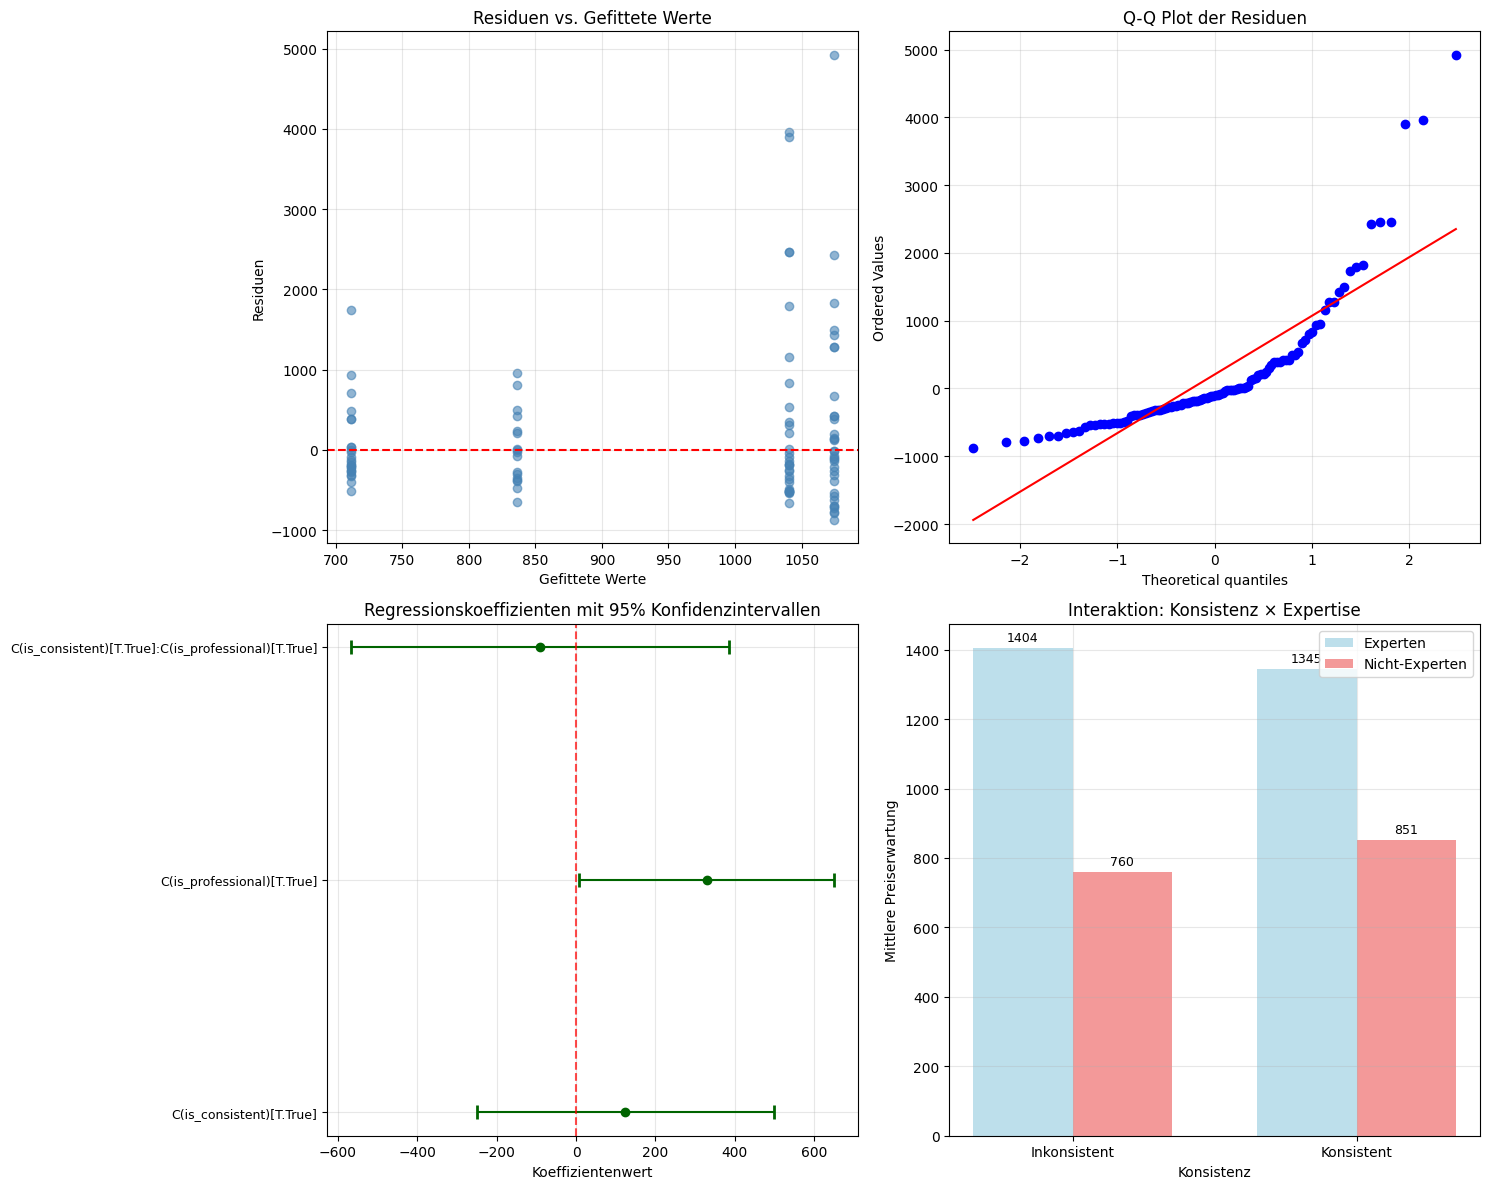


ROBUSTE REGRESSIONS-MODELL ZUSAMMENFASSUNG
Skala-Parameter = 561.640
Anzahl Beobachtungen = 106.0
Anzahl Parameter = 4

Signifikante Prädiktoren (p < 0.05):
  Intercept: β = 711.855, p = 0.000
  C(is_professional)[T.True]: β = 328.888, p = 0.045

Alle Koeffizienten:
  Intercept: β = 711.855, p = 0.000 ***
  C(is_consistent)[T.True]: β = 124.466, p = 0.514 
  C(is_professional)[T.True]: β = 328.888, p = 0.045 *
  C(is_consistent)[T.True]:C(is_professional)[T.True]: β = -90.850, p = 0.708 


In [131]:
# Visualisierung der Regressionsergebnisse
import matplotlib.patches as mpatches

# 1. Residuals vs Fitted Plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Residuen vs. gefittete Werte
fitted_values = model.fittedvalues
residuals = model.resid

ax1.scatter(fitted_values, residuals, alpha=0.6, color='steelblue')
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('Gefittete Werte')
ax1.set_ylabel('Residuen')
ax1.set_title('Residuen vs. Gefittete Werte')
ax1.grid(True, alpha=0.3)

# 2. QQ-Plot der Residuen
from scipy import stats
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot der Residuen')
ax2.grid(True, alpha=0.3)

# 3. Koeffizienten-Plot
coefficients = model.params[1:]  # Ohne Intercept
conf_int = model.conf_int()[1:]  # Ohne Intercept
coeff_names = coefficients.index

y_pos = np.arange(len(coeff_names))
ax3.errorbar(coefficients.values, y_pos, 
             xerr=[coefficients.values - conf_int.iloc[:, 0], 
                   conf_int.iloc[:, 1] - coefficients.values],
             fmt='o', capsize=5, capthick=2, color='darkgreen')
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.7)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(coeff_names, fontsize=9)
ax3.set_xlabel('Koeffizientenwert')
ax3.set_title('Regressionskoeffizienten mit 95% Konfidenzintervallen')
ax3.grid(True, alpha=0.3)

# 4. Interaktionseffekt visualisieren
interaction_data = combined_df.groupby(['is_consistent', 'is_professional'])['outfit_sum'].agg(['mean', 'std', 'count']).reset_index()

# Separate data for plotting
consistent_expert = interaction_data[(interaction_data['is_consistent'] == True) & (interaction_data['is_professional'] == True)]['mean'].values[0] if len(interaction_data[(interaction_data['is_consistent'] == True) & (interaction_data['is_professional'] == True)]) > 0 else 0
consistent_non_expert = interaction_data[(interaction_data['is_consistent'] == True) & (interaction_data['is_professional'] == False)]['mean'].values[0] if len(interaction_data[(interaction_data['is_consistent'] == True) & (interaction_data['is_professional'] == False)]) > 0 else 0
inconsistent_expert = interaction_data[(interaction_data['is_consistent'] == False) & (interaction_data['is_professional'] == True)]['mean'].values[0] if len(interaction_data[(interaction_data['is_consistent'] == False) & (interaction_data['is_professional'] == True)]) > 0 else 0
inconsistent_non_expert = interaction_data[(interaction_data['is_consistent'] == False) & (interaction_data['is_professional'] == False)]['mean'].values[0] if len(interaction_data[(interaction_data['is_consistent'] == False) & (interaction_data['is_professional'] == False)]) > 0 else 0

x_categories = ['Inkonsistent', 'Konsistent']
expert_means = [inconsistent_expert, consistent_expert]
non_expert_means = [inconsistent_non_expert, consistent_non_expert]

x = np.arange(len(x_categories))
width = 0.35

rects1 = ax4.bar(x - width/2, expert_means, width, label='Experten', color='lightblue', alpha=0.8)
rects2 = ax4.bar(x + width/2, non_expert_means, width, label='Nicht-Experten', color='lightcoral', alpha=0.8)

ax4.set_xlabel('Konsistenz')
ax4.set_ylabel('Mittlere Preiserwartung')
ax4.set_title('Interaktion: Konsistenz × Expertise')
ax4.set_xticks(x)
ax4.set_xticklabels(x_categories)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Werte auf den Balken anzeigen
def autolabel(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(ax4, rects1)
autolabel(ax4, rects2)

plt.tight_layout()
plt.show()

# Modell-Zusammenfassung ausgeben (für robuste Regression)
print("\n" + "="*60)
print("ROBUSTE REGRESSIONS-MODELL ZUSAMMENFASSUNG")
print("="*60)
print(f"Skala-Parameter = {model.scale:.3f}")
print(f"Anzahl Beobachtungen = {model.nobs}")
print(f"Anzahl Parameter = {len(model.params)}")

print("\nSignifikante Prädiktoren (p < 0.05):")
significant_predictors = model.pvalues[model.pvalues < 0.05]
for predictor, p_val in significant_predictors.items():
    coef = model.params[predictor]
    print(f"  {predictor}: β = {coef:.3f}, p = {p_val:.3f}")

print("\nAlle Koeffizienten:")
for predictor, coef in model.params.items():
    p_val = model.pvalues[predictor]
    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"  {predictor}: β = {coef:.3f}, p = {p_val:.3f} {significance}")

In [132]:

print("=== SCHRITTWEISE REGRESSION ===")
print("\n1. Nur Expertise (wie in ANOVA):")
model_1 = rlm('outfit_sum ~ C(is_professional)', data=combined_df).fit()
print(f"   Expertise: t = {model_1.tvalues['C(is_professional)[T.True]']:.3f}, p = {model_1.pvalues['C(is_professional)[T.True]']:.3f}")

print("\n2. Expertise + Liking:")
model_2 = rlm('outfit_sum ~ C(is_professional) + mean_liking', data=combined_df).fit()
print(f"   Expertise: t = {model_2.tvalues['C(is_professional)[T.True]']:.3f}, p = {model_2.pvalues['C(is_professional)[T.True]']:.3f}")
print(f"   Liking: t = {model_2.tvalues['mean_liking']:.3f}, p = {model_2.pvalues['mean_liking']:.3f}")

print("\n3. Expertise + Liking + Konsistenz:")
model_3 = rlm('outfit_sum ~ C(is_professional) + mean_liking + C(is_consistent)', data=combined_df).fit()
print(f"   Expertise: t = {model_3.tvalues['C(is_professional)[T.True]']:.3f}, p = {model_3.pvalues['C(is_professional)[T.True]']:.3f}")
print(f"   Liking: t = {model_3.tvalues['mean_liking']:.3f}, p = {model_3.pvalues['mean_liking']:.3f}")
print(f"   Konsistenz: t = {model_3.tvalues['C(is_consistent)[T.True]']:.3f}, p = {model_3.pvalues['C(is_consistent)[T.True]']:.3f}")

print("\n=== KORRELATIONSANALYSE ===")
# Korrelationen zwischen wichtigen Variablen
corr_vars = ['outfit_sum', 'mean_liking', 'is_professional', 'is_consistent']
corr_data = combined_df[corr_vars].copy()
corr_data['is_professional'] = corr_data['is_professional'].astype(int)
correlation_matrix = corr_data.corr()

print("\nKorrelationen:")
print(f"Expertise ↔ Liking: r = {correlation_matrix.loc['is_professional', 'mean_liking']:.3f}")
print(f"Expertise ↔ Preiserwartung: r = {correlation_matrix.loc['is_professional', 'outfit_sum']:.3f}")
print(f"Liking ↔ Preiserwartung: r = {correlation_matrix.loc['mean_liking', 'outfit_sum']:.3f}")

# Einfache Mediationsanalyse
print("\n=== MEDIATION CHECK ===")
# Pfad a: Expertise → Liking
model_a = rlm('mean_liking ~ C(is_professional)', data=combined_df).fit()
path_a = model_a.params['C(is_professional)[T.True]']
path_a_p = model_a.pvalues['C(is_professional)[T.True]']

# Pfad b: Liking → Preiserwartung (kontrolliert für Expertise)
model_b = rlm('outfit_sum ~ mean_liking + C(is_professional)', data=combined_df).fit()
path_b = model_b.params['mean_liking']
path_b_p = model_b.pvalues['mean_liking']

# Pfad c: Expertise → Preiserwartung (total effect)
model_c = rlm('outfit_sum ~ C(is_professional)', data=combined_df).fit()
path_c = model_c.params['C(is_professional)[T.True]']

# Pfad c': Expertise → Preiserwartung (kontrolliert für Liking)
path_c_prime = model_b.params['C(is_professional)[T.True]']

# Indirekter Effekt
indirect_effect = path_a * path_b

print(f"Pfad a (Expertise → Liking): β = {path_a:.3f}, p = {path_a_p:.3f}")
print(f"Pfad b (Liking → Preiserwartung): β = {path_b:.3f}, p = {path_b_p:.3f}")
print(f"Totaler Effekt (c): β = {path_c:.3f}")
print(f"Direkter Effekt (c'): β = {path_c_prime:.3f}")
print(f"Indirekter Effekt (a×b): β = {indirect_effect:.3f}")
print(f"Mediation: {(indirect_effect/path_c)*100:.1f}% des Gesamteffekts wird durch Liking mediiert")

=== SCHRITTWEISE REGRESSION ===

1. Nur Expertise (wie in ANOVA):
   Expertise: t = 2.536, p = 0.011

2. Expertise + Liking:
   Expertise: t = 2.087, p = 0.037
   Liking: t = 3.652, p = 0.000

3. Expertise + Liking + Konsistenz:
   Expertise: t = 2.069, p = 0.039
   Liking: t = 3.679, p = 0.000
   Konsistenz: t = 0.537, p = 0.592

=== KORRELATIONSANALYSE ===

Korrelationen:
Expertise ↔ Liking: r = 0.127
Expertise ↔ Preiserwartung: r = 0.275
Liking ↔ Preiserwartung: r = 0.228

=== MEDIATION CHECK ===
Pfad a (Expertise → Liking): β = 0.243, p = 0.271
Pfad b (Liking → Preiserwartung): β = 196.607, p = 0.000
Totaler Effekt (c): β = 288.465
Direkter Effekt (c'): β = 241.478
Indirekter Effekt (a×b): β = 47.724
Mediation: 16.5% des Gesamteffekts wird durch Liking mediiert


#### ANOVA

In [133]:
model = ols('outfit_sum ~ C(is_consistent) * C(is_professional)', data=combined_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("\nANOVA-Tabelle (Typ II):")
print(anova_table)


ANOVA-Tabelle (Typ II):
                                           sum_sq     df         F    PR(>F)
C(is_consistent)                     1.394880e+02    1.0  0.000140  0.990570
C(is_professional)                   8.226000e+06    1.0  8.278871  0.004885
C(is_consistent):C(is_professional)  1.389166e+05    1.0  0.139809  0.709247
Residual                             1.013486e+08  102.0       NaN       NaN


In [134]:
summarize_anova(anova_table)

Effekt 'C(is_consistent)': F(1) = 0.00, p = 0.991, η² = 0.000 (vernachlässigbar), nicht signifikant.
Effekt 'C(is_professional)': F(1) = 8.28, p = 0.005, η² = 0.075 (mittel), signifikant.
Effekt 'C(is_consistent):C(is_professional)': F(1) = 0.14, p = 0.709, η² = 0.001 (vernachlässigbar), nicht signifikant.
(α = 0.05)


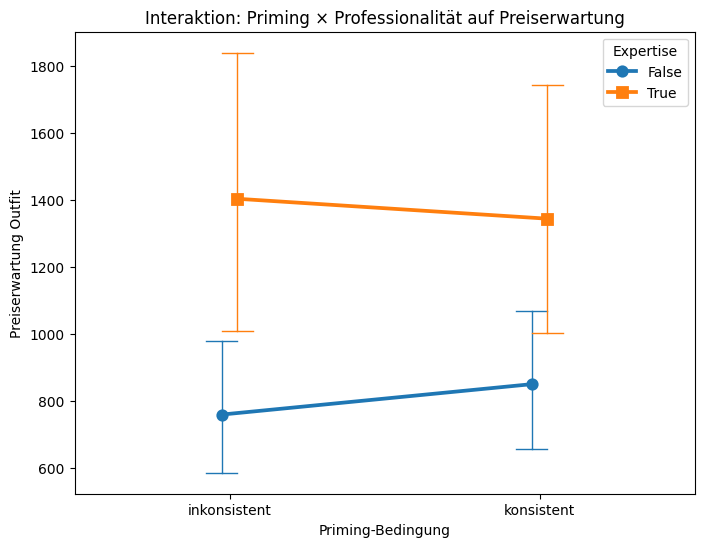

In [135]:
plt.figure(figsize=(8,6))
sns.pointplot(
    data=combined_df, x='priming', y='outfit_sum', hue='is_professional',
    dodge=True, markers=['o','s'], capsize=.1, err_kws={'linewidth': 1}
)
plt.title('Interaktion: Priming × Professionalität auf Preiserwartung')
plt.xlabel('Priming-Bedingung')
# plt.yticks(range(0, 6, 1))
plt.ylabel('Preiserwartung Outfit')
plt.xticks([0,1], ['inkonsistent',  'konsistent'])
plt.legend(title='Expertise')
plt.show()